In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/guofei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/guofei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/guofei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### 一、加载数据，数据可视化

In [2]:
housing = pd.read_csv('./data/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a16e972e8>,
      dtype=object)

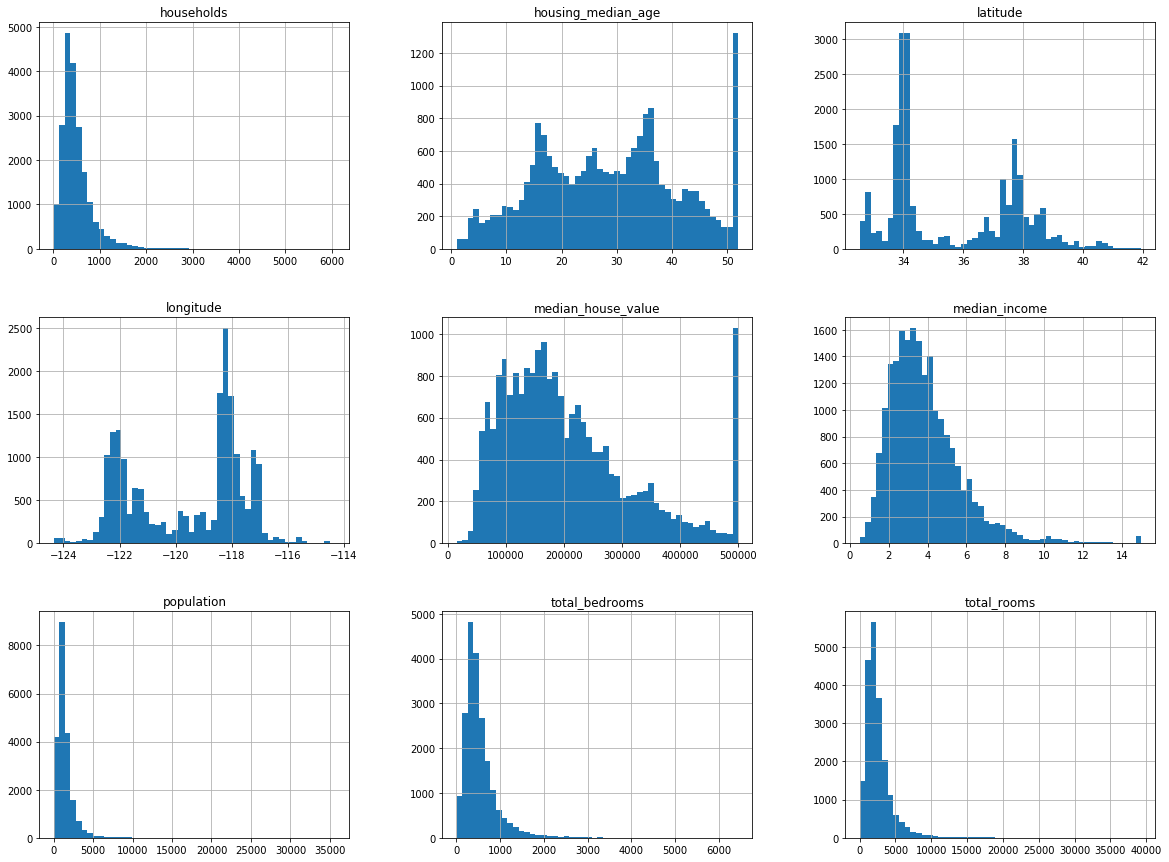

In [6]:
housing.hist(bins=50, figsize=(20,15))

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


通过观察直方图，可以发现如下的问题：
（1）收入设置了上下限
（2）房龄中位数和房价中位数存在上下限
对于此类数据，有两种解决方案：
（1）重新采集信息
（2）剔除这部分数据，这样训练集里没有上、下限之外的数据，这意味着在预测时，模型对于上、下限之外区域的预测能力会较弱
此外，还存在：
数据量度不一样——>特征缩放
数据偏斜——>调整为正态分布

### 二、数据集切分

In [8]:
# 1. 方法一：编写随机切分的函数, 这种方法的局限性在于随着数据集的改变，其选择的值

import numpy as np
def train_test_split(data, test_ratio):
    np.random.seed(42)   # 以保证每次的随机数一样
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    return data[train_indices], data[test_indices]

In [ ]:
# 2. 方法二：对数据ID进行hash值，取满足一定条件的哈希值作为测试集
import hashlib
def test_hash_check(identifier, test_ratio, method):
    return method(np.int64(identifier)).digest()[0] < 256 * test_ratio

def split_train_test_by_id(data,test_ratio, id_column, method=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda x: test_hash_check(x, test_ratio, method))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()   # 多了“index”一列
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

#  除了自动生成index，还可以采用样本独特的特征组合生成唯一的识别码，如在本例中可以采用“经度+维度”的形式
housing_with_id['id'] = housing['longitude'] * 1000, housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [ ]:
# 3. 方法三：采用sklearn自带的采样方法
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_seize=0.2, random_state=42)

In [9]:
# 4. 方法四：若完全随机采样，可能导致采样偏差（数据量较大时，可以接受），因此在很多情况下要根据某个重要特征进行分层采样

In [23]:
housing["income_cat"] = np.ceil(housing['median_income']/1.5)
housing["income_cat"].where(housing["income_cat"]<5,5, inplace=True)
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [25]:
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [27]:
# 分层采样
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [29]:
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

### 三、数据探索

将测试集放在一旁，仅对训练集进行探索。若测试集很大，可以再单独拿出一部分的作为探索集。

In [30]:
housing = strat_train_set.copy()    # 创建副本

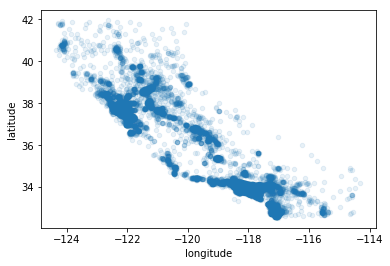

In [31]:
# 1. 房屋位置经纬度
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

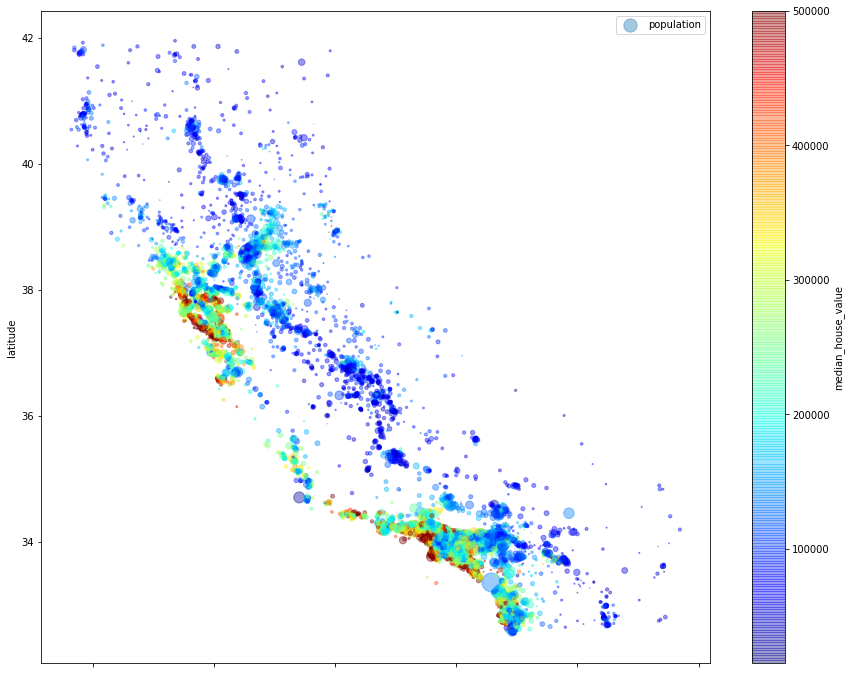

In [36]:
# 2. 房屋价格和人口
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population',
            c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,12))
plt.legend()

In [40]:
# 3. 查看特征相关性
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3e95c550>,
      dtype=object)

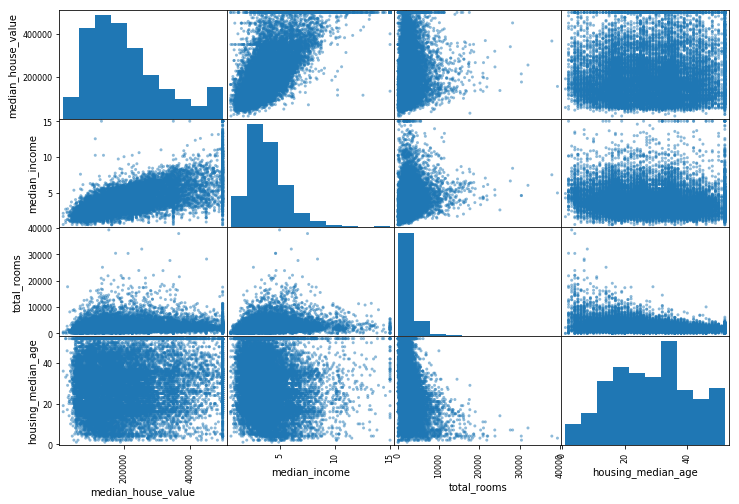

In [43]:
from pandas.tools.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

In [44]:
# 4. 属性组合试验：尝试得到一些新的特征
# 属性组合试验和模型的构建是一个交互的过程，通过模型的挖掘发现的规律需要重新回到数据进行进一步的清洗和整合
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### 四、数据准备

In [46]:
# 1. 复制训练集副本，同时将features和label分开
housing = strat_train_set.drop("median_house_value", axis=1)  # 创建副本，而不改变原数据，但若为inplace=True则会影响原数据
housing_labels = strat_train_set["median_house_value"].copy()

#### 4.1 缺失值处理

In [47]:
# 缺失值的处理有三种思路：（1）去处样本；（2）去处特征；（3）缺失值填充。这里选择中位数填充
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')   # 仅能作用于数值特征
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)    # 训练缺失值填充器

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [48]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [50]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [51]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

#### 4.2 处理文本和类别属性

In [53]:
housing_cat = housing["ocean_proximity"]
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [59]:
# 对上面的编码再进行one-hot编码，或者直接采用CategoricalEncoder
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.values.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

#### 4.3 将上述变换过程封装成函数和类，以供训练集和测试集直接使用

In [62]:
# 1. 选取相关的特征
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [65]:
selector = DataFrameSelector(["ocean_proximity"])
selector.fit_transform(housing)

array([['<1H OCEAN'],
       ['<1H OCEAN'],
       ['NEAR OCEAN'],
       ...,
       ['INLAND'],
       ['<1H OCEAN'],
       ['NEAR BAY']], dtype=object)

In [72]:
# 2.特征组合
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # 超参数
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [73]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
print(housing_extra_attribs.shape)

(16512, 11)


In [82]:
# 3. 文本类型数据转换
"""
！有问题，无法保证fit和transform的一致性，后面直接用Onehot编码
"""
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class CatAttributesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder1 = LabelEncoder()
        self.encoder2 = OneHotEncoder()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_cat_encoded = self.encoder1.fit_transform(X.reshape(-1,1))
        cat_1hot = self.encoder2.fit_transform(X_cat_encoded.reshape(-1,1))
        return cat_1hot.toarray()

In [83]:
cat_attri_encoder = CatAttributesTransformer()
cat_attri_encoder.fit_transform(housing["ocean_proximity"].values)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [106]:
# 4. 对上述的转换器进行pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)), ('imputer', Imputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),('std_scaler', StandardScaler())])
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)), ('cat_encoder', OneHotEncoder())])

full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline), ("cat_pipeline", cat_pipeline)])

In [107]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

### 五、训练模型

In [108]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [113]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)


In [114]:
some_data_prepared.shape

(5, 16)

In [115]:
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [210644.60470466 317768.80720328 210956.43327566  59218.98853655
 189747.55851323]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [117]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [118]:
housing_labels.describe()

count     16512.000000
mean     206990.920724
std      115703.014830
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [119]:
# 上面发现rmse比较大，选择一个更强大的模型
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [120]:
lin_mse = mean_squared_error(housing_labels, tree_reg.predict(housing_prepared))
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.0

In [121]:
# 虽然上面的rmse为0，但可能为过拟合，采取交叉验证以用更少的数据（不污染测试集）来检查模型的泛化能力
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
rmse_scores

array([69652.37464451, 67244.28817151, 70590.48542134, 69416.94002622,
       72051.24359269, 75701.59655716, 70166.14805279, 71285.70655113,
       78634.39124928, 72023.67363209])

In [122]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

Scores: [69652.37464451 67244.28817151 70590.48542134 69416.94002622
 72051.24359269 75701.59655716 70166.14805279 71285.70655113
 78634.39124928 72023.67363209]
Mean: 71676.68478987194
Standard deviation: 3119.8577129817163


In [124]:
# 再对比线性模型的交叉验证
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)


Scores: [66782.73844036 66960.11809129 70347.95244107 74739.57053185
 68031.13387035 71193.84182238 64969.63056504 68281.6113794
 71552.91572083 67665.10081721]
Mean: 69052.46136797857
Standard deviation: 2731.6740062578233


In [126]:
# 可见决策树更过拟合，再尝试随机森林模型
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(housing_prepared, housing_labels)
rf_mse = mean_squared_error(housing_labels, rf_reg.predict(housing_prepared))
rf_rmse = np.sqrt(rf_mse)
rf_rmse

22352.781952008518

In [127]:
scores = cross_val_score(rf_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [52613.75278247 49770.40247587 53658.89329494 55333.86520978
 52091.13718792 56018.13876322 52324.60451706 50167.63471133
 54706.74633494 52419.88825102]
Mean: 52910.5063528536
Standard deviation: 1950.4774089660825


In [128]:
# 比较训练集和验证集的rmse，可见模型仍然过拟合,采用网格搜索寻找最优参数
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

rf_reg = RandomForestRegressor()
grid_serach = GridSearchCV(rf_reg, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5)
grid_serach.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [132]:
cvres = grid_serach.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63888.98431364996 {'max_features': 2, 'n_estimators': 3}
55020.08829677043 {'max_features': 2, 'n_estimators': 10}
52817.01095562102 {'max_features': 2, 'n_estimators': 30}
60133.912835737596 {'max_features': 4, 'n_estimators': 3}
52939.792823492906 {'max_features': 4, 'n_estimators': 10}
50437.321800534795 {'max_features': 4, 'n_estimators': 30}
59414.30434234763 {'max_features': 6, 'n_estimators': 3}
52506.686598596934 {'max_features': 6, 'n_estimators': 10}
50231.197278228086 {'max_features': 6, 'n_estimators': 30}
58691.914426285104 {'max_features': 8, 'n_estimators': 3}
51859.648985861764 {'max_features': 8, 'n_estimators': 10}
50211.17706670653 {'max_features': 8, 'n_estimators': 30}
62129.62515797785 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54054.296503451544 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60119.05133416726 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52845.236602088284 {'bootstrap': False, 'max_features': 3, 'n_estima

In [136]:
# 同下面的方法
print(grid_serach.best_estimator_)
print(grid_serach.best_params_)
print(np.sqrt(-grid_serach.best_score_))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
{'max_features': 8, 'n_estimators': 30}
50211.17706670653


In [152]:
# 特征重要性排序
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
list(housing_num.columns)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [153]:
list(cat_encoder.categories_[0])

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [154]:
feature_list = list(housing_num.columns)+extra_attribs+list(cat_encoder.categories_[0])
feature_list

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [155]:
sorted(zip(grid_serach.best_estimator_.feature_importances_, feature_list), reverse=True)

[(0.3741944270357566, 'median_income'),
 (0.15834411576796378, 'INLAND'),
 (0.10836664516891124, 'pop_per_hhold'),
 (0.07394368702982829, 'longitude'),
 (0.06388927019665015, 'latitude'),
 (0.056429969248885485, 'bedrooms_per_room'),
 (0.04867992985521627, 'rooms_per_hhold'),
 (0.04235805630154764, 'housing_median_age'),
 (0.015549556408367672, 'total_rooms'),
 (0.015038819047576691, 'households'),
 (0.014849530314006909, 'population'),
 (0.01461208314094583, 'total_bedrooms'),
 (0.006907536534594705, '<1H OCEAN'),
 (0.0047074280909149575, 'NEAR OCEAN'),
 (0.0020745466657632796, 'NEAR BAY'),
 (5.4399193070468615e-05, 'ISLAND')]

### 六、进行测试

In [158]:
final_model = grid_serach.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47661.00986614512